In [ ]:
import pandas as pd
import folium
import math
import numpy as np
import re
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim import corpora
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))
nltk.download('punkt')     # comment out if already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models


In [ ]:
# drop column
from google.colab import drive
drive.mount("/content/drive")
path="/content/drive/MyDrive/M2/Reviews_w_sentiment_score_data.csv"


reviews_df = pd.read_csv(path, lineterminator = '\n')

# reviews_df = pd.read_csv('Reviews_w_sentiment_score_data.csv', lineterminator = '\n')
NMF_df = reviews_df.copy()

# NMF_df = NMF_df.head(100)

# LDA_df = LDA_df.drop('cleaned_comments_nltk', axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cleaning the dataset to remove all stopwords from our custom list. Also removing all numbers, turning text into lowercase, and removing punctuation and symbols. We used WordNetLemmatizer() to lemmatize the words. This Lemmatizes using WordNet's built-in morphy function and returns the input word unchanged if it cannot be found in WordNet. Finally, we tokenized the text using nltk.

In [ ]:
def data_cleaning(text, stem = "None"):

    final_string = ""

    # cleaning
    text = text.lower()
    text = re.sub(r'\n', '', text)

    # removing symbols and punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.split()

    # Add stopwords
    extra_words = nltk.corpus.stopwords.words("english")
    extend_stopwords = ['hi', 'im','i','los', 'angeles','stay','flat','room','place','apartment','u','would','really',
                        'airbnb','good','nice','great','didnt','lovely','amazing', 'bnb', 'santa', 'monica', 'well',
                        'not', 'highly', 'thank', 'perfect', 'everything', 'not', 'house', 'home', 'can', 'everything',
                        'ive', 'ever', 'one', 'like', 'felt', 'loved', 'super', 'definitely', 'recommend'
                       'back', 'come', 'venice', 'la', 'night', 'get', 'even', 'day', 'dont', 'go', 'also', 'thing']
    extra_words.extend(extend_stopwords)

    cleaned_text = [word for word in text if not word in extra_words]

    # getting rid of numbers
    cleaned_text = [re.sub(r'\w*\d\w*', '', w) for w in cleaned_text]

    # Stem or Lemmatize
    if stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in cleaned_text]
    else:
        text_stemmed = cleaned_text

    stem_clean = [word for word in text_stemmed if not word in extra_words]
    final_string = ' '.join(stem_clean)

    result = nltk.word_tokenize(final_string)

    return result

Additional cleaning and making a new column.

In [ ]:
# Create new column
NMF_df['cleaned_comments_nltk'] = NMF_df['comments2'].apply(data_cleaning, stem='Lem')

In [ ]:
# # replace brackets, comma and apostrophe
NMF_df['cleaned_comments_nltk'] = NMF_df['cleaned_comments_nltk'].astype(str)
NMF_df['cleaned_comments_nltk'] = NMF_df['cleaned_comments_nltk'].str.replace('[', '').str.replace(']', '').str.replace(',', '').str.replace("'", "")

<ipython-input-13-833e793516cf>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  NMF_df['cleaned_comments_nltk'] = NMF_df['cleaned_comments_nltk'].str.replace('[', '').str.replace(']', '').str.replace(',', '').str.replace("'", "")


In [ ]:
NMF_df.head()

,Unnamed: 0,listing_id,reviewer_name,comments2,id,final_review_score,score_label,Sentiment_Score,Sentiment,normalized_Sentiment_score,normalize_rating_score,cleaned_comments_nltk
0,0,109,Edwin,The host canceled my reservation the day befor...,109,4.285714,high,0.0000,Neutral,2.50,4.25,host canceled reservation arrival
1,1,109,Jenn,Me and two friends stayed for four and a half ...,109,4.285714,high,0.9316,Positive,4.75,4.25,two friend stayed four half month comfortable ...
2,2,2708,Kuberan,i had a wonderful stay. Everything from start ...,2708,4.912857,high,0.8126,Positive,4.50,5.00,wonderful start end back
3,3,2708,Camilla,Charles is just amazing and he made my stay sp...,2708,4.912857,high,0.9909,Positive,5.00,5.00,charles made special helpful absolutely polite...
4,4,2708,Fallon,Staying with Chas was an absolute pleasure. He...,2708,4.912857,high,0.9672,Positive,5.00,5.00,staying chas absolute pleasure accommodating r...
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,180926,Leatt,"Beautiful place! The cottage was very cozy, an...",180926,4.905714,high,0.9602,Positive,5.00,5.00,beautiful cottage cozy local hikesincredible r...
96,96,180926,Sebastian,My girlfriend and I loved our little getaway f...,180926,4.905714,high,0.9802,Positive,5.00,5.00,girlfriend little getaway birthday area surrou...
97,97,180926,Alexis,Rebeccas airbnb was the cutest getaway spot. I...,180926,4.905714,high,0.9892,Positive,5.00,5.00,rebecca cutest getaway spot admit surrounding ...
98,98,180926,Joel,Cozy cabin in nature.,180926,4.905714,high,0.0000,Neutral,2.50,5.00,cozy cabin nature


In [ ]:
# save this cleaned comments to csv, and work in a new notebook
# NMF_df.to_csv('cleaned_nmf.csv', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel
from sklearn.decomposition import NMF
from operator import itemgetter
''' This module aims to implement Non-Negative Matrix Factorization as a
technique for topic modeling and since this approach has been proved to be
efficient in terms of time complexity, it can be employed to have an estimation
 of topic numbers.
'''
def NMF(corpus, num_topics, dic):
    nmf = Nmf(corpus=corpus, num_topics=num_topics, id2word=dic,chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42)
    return nmf

def get_coherence(model, word_bigrams, dic):
    cm = CoherenceModel(
        model=model,
        texts=word_bigrams,
        dictionary=dic,
        coherence='c_v')
    return round(cm.get_coherence(), 5)

def num_topics_estimation(corpus, dic, word_bigrams, lower_bound, upper_bound, step=1):
    topic_nums = list(np.arange(lower_bound, upper_bound, step))
    coherence_scores = []
    for num in topic_nums:
        nmf = NMF(corpus, num, dic)
        coherence_scores.append(get_coherence(nmf, word_bigrams, dic))
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
    print('%d topics would be estimated for this data' % best_num_topics)
    return best_num_topics, scores

def illustrate_word_clouds(model):
    for t in range(model.num_topics):
        plt.figure()
        plt.imshow(wordcloud.WordCloud().fit_words(dict(model.show_topic(t, 10))))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()


In [ ]:
def calculate_coherence(nmf_model, texts, dictionary):
    coherence_model = CoherenceModel(model=nmf_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

In [ ]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize
# Range to find the best number of topics
start = 2
stop = 12
step = 2

# data = NMF_df['cleaned_comments_nltk'].apply(lambda x: )

NMF_df['newColumn'] = NMF_df['cleaned_comments_nltk'].apply(lambda x: word_tokenize(x.lower()))
data = NMF_df['newColumn']

tokenized_data = data

# Step 1 Tokenization
# tokenized_data = [word_tokenize(text.lower()) for text in data]

# Step 2: Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(tokenized_data)

# Step 3: Convert the list of documents (corpus) into Document-Term Matrix using the dictionary.
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_data]

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Num_Topics', 'Coherence_Score'])

# Apply to NMF model
for num_topics in tqdm(range(start, stop, step), desc="Calculating Coherence"):

    nmf_model = NMF(corpus=corpus, num_topics=num_topics, dic=dictionary)
    coherence = calculate_coherence(nmf_model, tokenized_data, dictionary)
    # Append results to the DataFrame
    results_df = results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)

print(results_df)

Calculating Coherence:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
results_df

Above this cell is the required NMF coherence score calculation run on the entire NMF dataframe.

In [ ]:
# sample1000 = NMF_df.sample(1000)

In [ ]:
positive_df = NMF_df[NMF_df['Sentiment'] == 'Positive']
positive_df.size

15793596

In [ ]:
positive_df.sample(3)

,Unnamed: 0,listing_id,reviewer_name,comments2,id,final_review_score,score_label,Sentiment_Score,Sentiment,normalized_Sentiment_score,normalize_rating_score,cleaned_comments_nltk,newColumn
205097,205097,4988069,Rachel,Great little cabin in a quiet neighborhood. We...,4988069,4.900000,high,0.9477,Positive,4.75,5.00,little cabin quiet neighborhood time relaxing ...,"[little, cabin, quiet, neighborhood, time, rel..."
190066,190066,4365999,Lawana,These Hosts Are Amazing!!! Quick Responses Ve...,4365999,4.942857,high,0.8770,Positive,4.75,5.00,host quick response engaging needed check earl...,"[host, quick, response, engaging, needed, chec..."
1175851,1175851,52107791,Christina,This is a lovely apartment. The rooftop was ab...,52107791,4.682857,high,0.9855,Positive,5.00,4.75,rooftop absolutely pool heated open late build...,"[rooftop, absolutely, pool, heated, open, late..."


In [ ]:
tokenized_pos = positive_df['newColumn']

dictionary = corpora.Dictionary(tokenized_pos)

corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_pos]

In [ ]:
# Range to find the best number of topics
start = 2
stop = 12
step = 1

In [ ]:
# Initialize a DataFrame to store the results
pos_results_df = pd.DataFrame(columns=['Num_Topics', 'Coherence_Score'])

# Apply to NMF model
for num_topics in tqdm(range(start, stop, step), desc="Calculating Coherence"):

    nmf_model = NMF(corpus=corpus, num_topics=num_topics, dic=dictionary)
    coherence = calculate_coherence(nmf_model, tokenized_data, dictionary)
    # Append results to the DataFrame
    pos_results_df = pos_results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)


Calculating Coherence:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-90-e51377be959d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos_results_df = pos_results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)
Calculating Coherence:  10%|█         | 1/10 [20:15<3:02:21, 1215.69s/it]<ipython-input-90-e51377be959d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos_results_df = pos_results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)
Calculating Coherence:  20%|██        | 2/10 [41:53<2:48:32, 1264.07s/it]<ipython-input-90-e51377be959d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pos_results_df = pos_results_df.append({'Num_Top

In [ ]:
pos_results_df

,Num_Topics,Coherence_Score
0,2.0,0.538361
1,3.0,0.536470
2,4.0,0.531384
3,5.0,0.544091
4,6.0,0.564518
5,7.0,0.542648
6,8.0,0.581976
7,9.0,0.564400
8,10.0,0.555308
9,11.0,0.561752


In [ ]:
# best number of topic with highest coherence score
pos_best_n_topic = pos_results_df['Num_Topics'][pos_results_df['Coherence_Score'].idxmax()]
pos_best_n_topic = pos_best_n_topic.astype(int)
pos_best_n_topic

8

Best number of topic for positive: 8


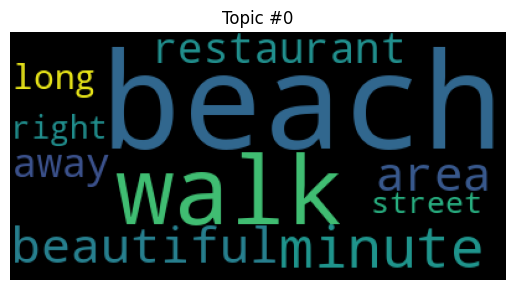

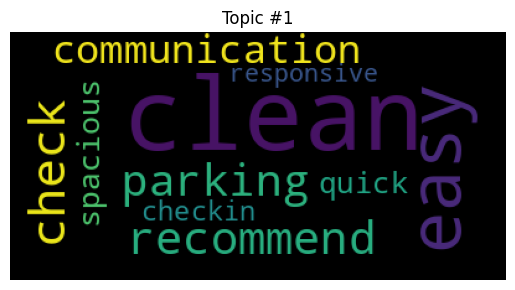

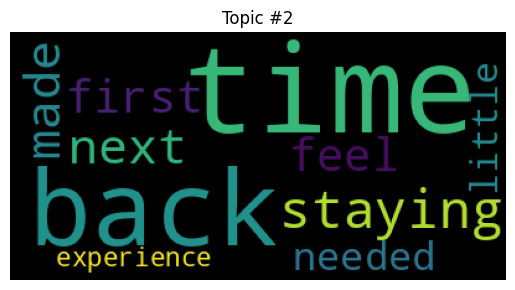

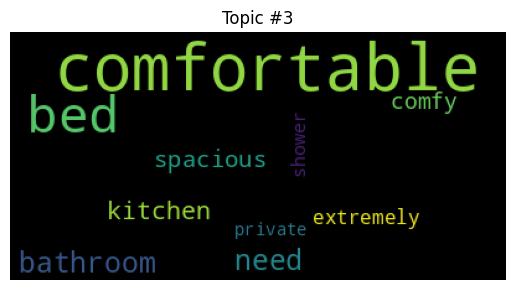

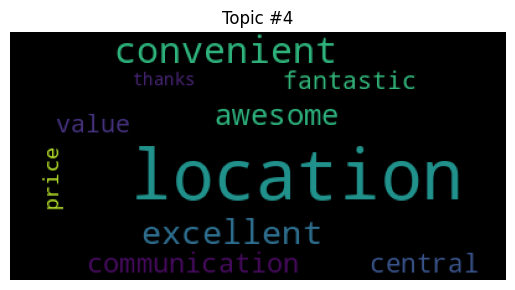

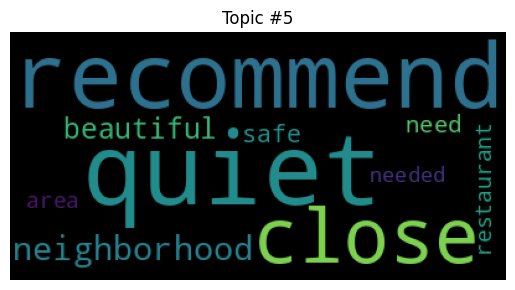

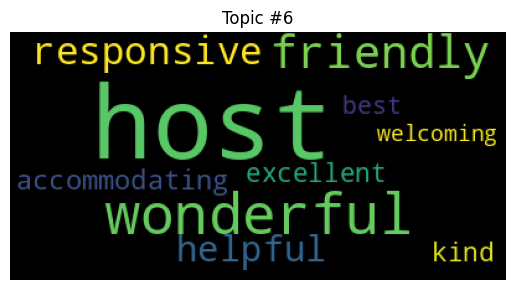

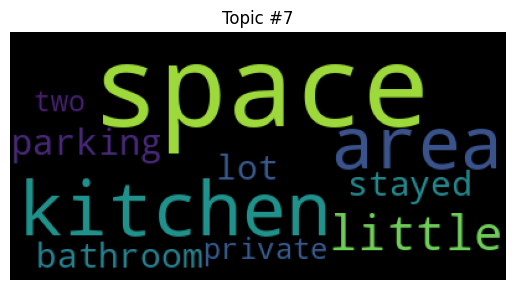

In [ ]:
# Apply NMF with the best number of topics
nmf_model = NMF(corpus, pos_best_n_topic, dic=dictionary)

print("Best number of topic for positive:", pos_best_n_topic)

# Visualize word clouds for each topic
illustrate_word_clouds(nmf_model)

----------------
Negative Comments

In [ ]:
negative_df = NMF_df[NMF_df['Sentiment'] == 'Negative']
negative_df.size

132275

In [ ]:
tokenized_neg = negative_df['newColumn']

dictionary = corpora.Dictionary(tokenized_neg)

corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_neg]

In [ ]:
# Range to find the best number of topics
start = 2
stop = 10
step = 1

In [ ]:
# Initialize a DataFrame to store the results
neg_results_df = pd.DataFrame(columns=['Num_Topics', 'Coherence_Score'])

# Apply to NMF model
for num_topics in tqdm(range(start, stop, step), desc="Calculating Coherence"):

    nmf_model = NMF(corpus=corpus, num_topics=num_topics, dic=dictionary)
    coherence = calculate_coherence(nmf_model, tokenized_data, dictionary)
    # Append results to the DataFrame
    neg_results_df = neg_results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)

Calculating Coherence:   0%|          | 0/8 [00:00<?, ?it/s]<ipython-input-107-a751b6554b56>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_results_df = neg_results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)
Calculating Coherence:  12%|█▎        | 1/8 [01:31<10:43, 91.89s/it]<ipython-input-107-a751b6554b56>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_results_df = neg_results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)
Calculating Coherence:  25%|██▌       | 2/8 [02:45<08:07, 81.25s/it]<ipython-input-107-a751b6554b56>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neg_results_df = neg_results_df.append({'Num_Topics': nu

In [ ]:
neg_results_df

,Num_Topics,Coherence_Score
0,2.0,0.707113
1,3.0,0.705225
2,4.0,0.728728
3,5.0,0.757574
4,6.0,0.752590
5,7.0,0.741955
6,8.0,0.749824
7,9.0,0.752949


In [ ]:
# best number of topic with highest coherence score
neg_best_n_topic = neg_results_df['Num_Topics'][neg_results_df['Coherence_Score'].idxmax()]
neg_best_n_topic = neg_best_n_topic.astype(int)
neg_best_n_topic

5

Best number of topic for negative: 5


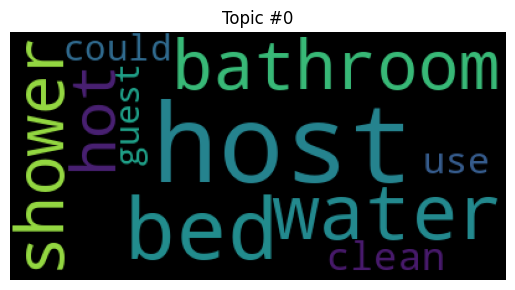

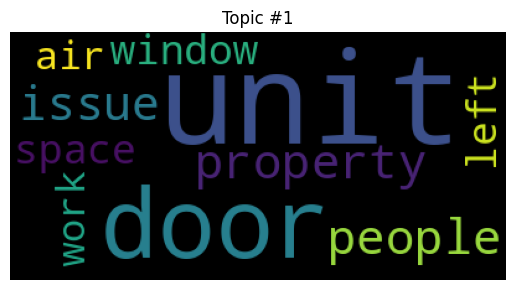

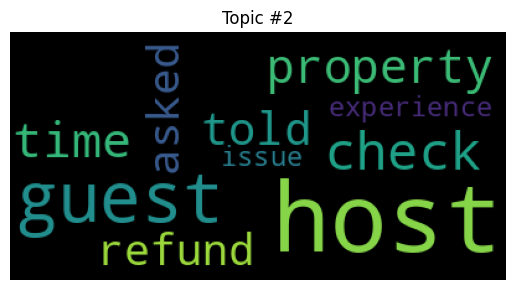

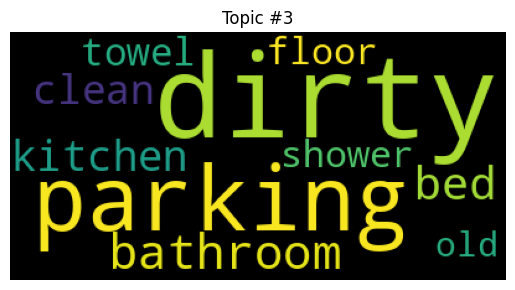

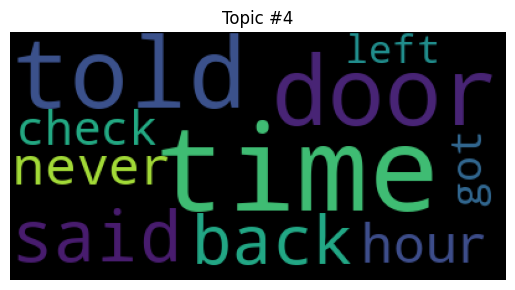

In [ ]:
# Apply NMF with the best number of topics
nmf_model_neg = NMF(corpus, neg_best_n_topic, dic=dictionary)

print("Best number of topic for negative:", neg_best_n_topic)

# Visualize word clouds for each topic
illustrate_word_clouds(nmf_model_neg)

---------

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

###### Positive


# Preprocess the text data
processed_comments = positive_df['cleaned_comments_nltk'].apply(simple_preprocess)

# Build a dictionary
dic = Dictionary(processed_comments)

# Create a corpus
corpus = [dic.doc2bow(comment) for comment in processed_comments]

# Set the lower bound, upper bound, and step for topic number estimation
lower_bound = 2
upper_bound = 10
step = 1

# Estimate the number of topics
best_num_topics, scores = num_topics_estimation(corpus, dic, processed_comments, lower_bound, upper_bound, step)

# Apply NMF with the best number of topics
nmf_model = NMF(corpus, best_num_topics, dic)

# Get coherence score
coherence_score = get_coherence(nmf_model, processed_comments, dic)
print("Best number of topic for positive:", best_num_topics)
print("Coherence Score:", coherence_score)


# Visualize word clouds for each topic
illustrate_word_clouds(nmf_model)

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

###### Negative

negative_df = NMF_df[NMF_df['Sentiment'] == 'Negative']

# Preprocess the text data
processed_comments = negative_df['cleaned_comments_nltk'].apply(simple_preprocess)

# Build a dictionary
dic = Dictionary(processed_comments)

# Create a corpus
corpus = [dic.doc2bow(comment) for comment in processed_comments]

# Set the lower bound, upper bound, and step for topic number estimation
lower_bound = 2
upper_bound = 10
step = 1

# Estimate the number of topics
best_num_topics, scores = num_topics_estimation(corpus, dic, processed_comments, lower_bound, upper_bound, step)

# Apply NMF with the best number of topics
nmf_model = NMF(corpus, best_num_topics, dic)

# Get coherence score
coherence_score = get_coherence(nmf_model, processed_comments, dic)
print("Best number of topic for negative:", best_num_topics)
print("Coherence Score:", coherence_score)

# Visualize word clouds for each topic
illustrate_word_clouds(nmf_model)

NameError: ignored

In [ ]:
print("Best number of topic for positive:", best_num_topics)
neutral_df = NMF_df[NMF_df['Sentiment'] == 'Neutral']
neutral_df.size

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

###### Neutral

# Preprocess the text data
processed_comments = neutral_df['cleaned_comments_nltk'].apply(simple_preprocess)

# Build a dictionary
dic = Dictionary(processed_comments)

# Create a corpus
corpus = [dic.doc2bow(comment) for comment in processed_comments]

# Set the lower bound, upper bound, and step for topic number estimation
lower_bound = 2
upper_bound = 10
step = 1

# Estimate the number of topics
best_num_topics, scores = num_topics_estimation(corpus, dic, processed_comments, lower_bound, upper_bound, step)

# Apply NMF with the best number of topics
nmf_model = NMF(corpus, best_num_topics, dic)

# Get coherence score
coherence_score = get_coherence(nmf_model, processed_comments, dic)
print("Coherence Score:", coherence_score)

# Visualize word clouds for each topic
illustrate_word_clouds(nmf_model)